In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm
import json
import pandas as pd

2024-11-08 01:03:35.779187: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 01:03:35.802459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 01:03:35.802479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 01:03:35.803545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 01:03:35.807881: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


/home/mahfuj/miniconda3/envs/tf_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(dir):
    with open(f'{dir}/_annotations.coco.json') as f:
        j = json.load(f)

    class_mapping = {c['id']: c['name'] for c in j['categories']}

    image_paths = [f'{dir}/{d["file_name"]}' for d in j['images']]
    len(image_paths)

    classes = [[] for _ in image_paths]
    bounding_boxes = [[] for _ in image_paths]

    for a in j['annotations']:
        idx = a['image_id']
        classes[idx].append(a['category_id'])
        bounding_boxes[idx].append(a['bbox'])

    bbox =  tf.ragged.constant(bounding_boxes)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)

    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    return data, class_mapping

In [3]:
train_dir = 'data/train'
val_dir = 'data/valid'
test_dir = 'data/test'

train_data, class_mapping = load_data(train_dir)
val_data, _ = load_data(val_dir)
test_data, _ = load_data(test_dir)

len(train_data), len(val_data), len(test_data)

2024-11-08 01:03:37.127505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 01:03:37.127656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-08 01:03:37.153906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(8619, 607, 624)

In [4]:
train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))>

In [5]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def load_dataset(image_path, classes, bbox):
    image = load_image(image_path)
    print(image)
    bounding_boxes = {
        'classes': tf.cast(classes, dtype=tf.float32),
        'boxes': bbox
    }
    return {
        'images': tf.cast(image, tf.float32),
        'bounding_boxes': bounding_boxes
    }

In [6]:
BATCH_SIZE = 4

In [7]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode='horizontal', bounding_box_format='xywh'),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format='xywh'
        ),
        keras_cv.layers.JitteredResize(
            target_size=(256,256), scale_factor=(0.75, 1.3), bounding_box_format='xywh',
        ),
    ]
)

In [8]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)


In [9]:
train_ds

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, None]), tf.float32, 1, tf.int64)}}>

In [10]:
val_augmenter = keras.Sequential(
    layers=[
        # keras_cv.layers.JitteredResize(
        #     target_size=(256,256), scale_factor=(0.75, 1.3), bounding_box_format='xywh',
        # ),
        keras_cv.layers.Resizing(
            256, 256, bounding_box_format='xywh', pad_to_aspect_ratio=True
        )
    ]
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(val_augmenter, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = test_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(BATCH_SIZE * 4)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.map(val_augmenter, num_parallel_calls=tf.data.AUTOTUNE)

Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)


In [11]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    # print(inputs)
    images, bounding_boxes = inputs['images'], inputs['bounding_boxes']

    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=3,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping
    )

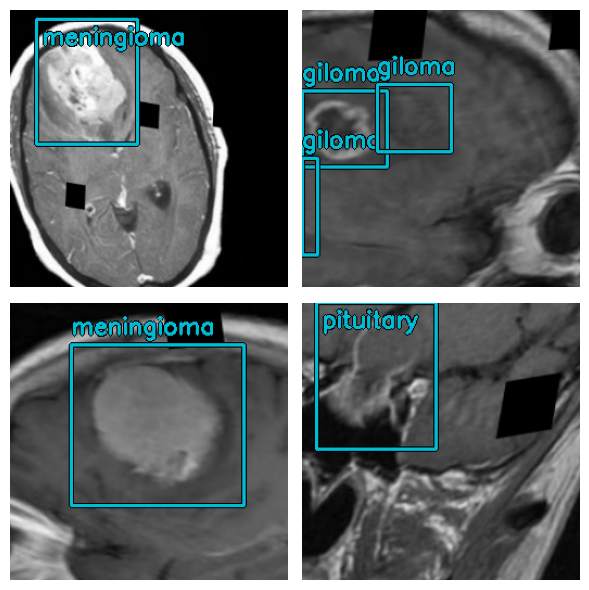

In [12]:
visualize_dataset(
    train_ds, bounding_box_format='xywh', value_range=(0,255), rows=2, cols=2
)

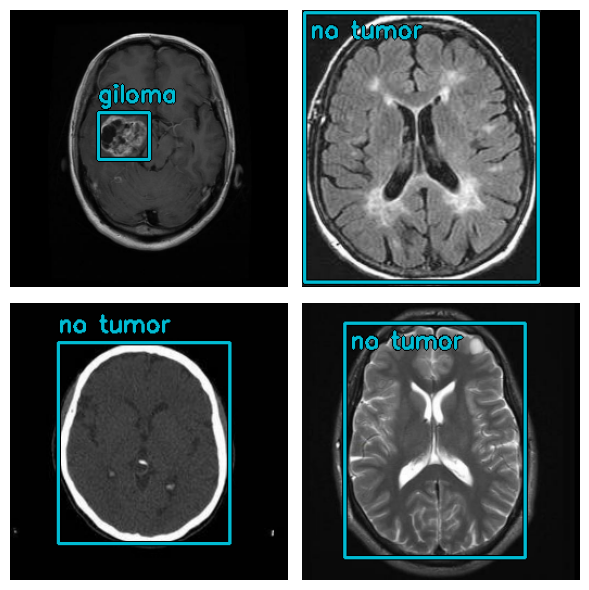

In [13]:
visualize_dataset(
    val_ds, bounding_box_format='xywh', value_range=(0,255), rows=2, cols=2
)

In [14]:
def dict_to_tuple(inputs):
    return inputs['images'], bounding_box.to_dense(
        inputs['bounding_boxes'], max_boxes = 32
    )

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [15]:
base_lr = 0.005

optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [16]:
model = keras_cv.models.RetinaNet.from_preset(
    'resnet50_imagenet',
    num_classes=len(class_mapping),
    bounding_box_format='xywh',
)

2024-11-08 01:03:43.597535: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [17]:
model.summary()

Model: "retina_net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 images (InputLayer)         [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    2356115   ['images[0][0]']              
                             512),                        2                                       
                              'P4': (None, None, None,                                            
                             1024),                                                               
                              'P5': (None, None, None,                                            
                             2048)}                                                      

In [18]:
model.compile(
    classification_loss = 'focal',
    box_loss = 'smoothl1',
    optimizer = optimizer,
)

In [19]:
class SaveBestMAPCallback(tf.keras.callbacks.Callback):
    def __init__(self, coco_metrics_callback, save_path="best_model/", monitor="val_AP"):
        super(SaveBestMAPCallback, self).__init__()
        self.coco_metrics_callback = coco_metrics_callback
        self.save_path = save_path
        self.monitor = monitor
        self.best_map = 0.0

    def on_epoch_end(self, epoch, logs=None):
        # Get the mAP from the COCO callback
        current_map = logs.get(self.monitor)
        
        # Only proceed if mAP is available in logs
        if current_map is not None:
            # Check if the current mAP is the best one so far
            if current_map > self.best_map:
                self.best_map = current_map
                self.model.save_weights(self.save_path)
                print(f"\nEpoch {epoch + 1}: mAP improved to {current_map:.4f}, saving model to {self.save_path}")
        else:
            print(f"Warning: '{self.monitor}' not found in logs. Make sure PyCOCOCallback is logging it correctly.")



In [ ]:
# coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback (
#     test_ds, bounding_box_format="xywh"
# )

# save_best_map_callback = SaveBestMAPCallback(coco_metrics_callback, save_path="trained_models/best_model/")

# # callbacks=[EvaluateCOCOMetricsCallback(val_ds.take(20), "best_model.keras")]

# history = model.fit(
#     train_ds,
#     validation_data = val_ds,
#     epochs = 80,
#     callbacks=[coco_metrics_callback, save_best_map_callback]
# )
# model.save_weights ('trained_models/last_model/', overwrite=True)

# history_df = pd.DataFrame(history.history)
# history_df.to_csv('history.csv')

In [21]:
from tensorflow.keras.models import load_model

# Load the entire model (architecture, weights, optimizer state)
model.load_weights('trained_models/best_model/')

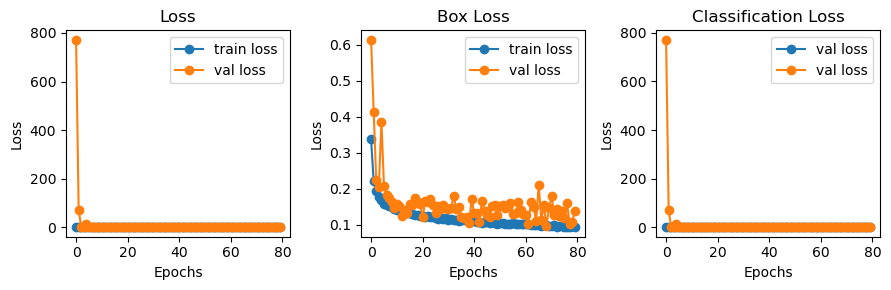

In [22]:
import matplotlib.pyplot as plt

history_df = pd.read_csv('history.csv')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].plot(history_df['loss'], 'o-', label="train loss")
axes[0].plot(history_df['val_loss'], 'o-', label="val loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(history_df['box_loss'], 'o-', label="train loss")
axes[1].plot(history_df['val_box_loss'], 'o-', label="val loss")
axes[1].set_title("Box Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

axes[2].plot(history_df['classification_loss'], 'o-', label="val loss")
axes[2].plot(history_df['val_classification_loss'], 'o-', label="val loss")
axes[2].set_title("Classification Loss")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Loss")
axes[2].legend()

plt.tight_layout()
plt.savefig('history.png', dpi=200)

plt.show()

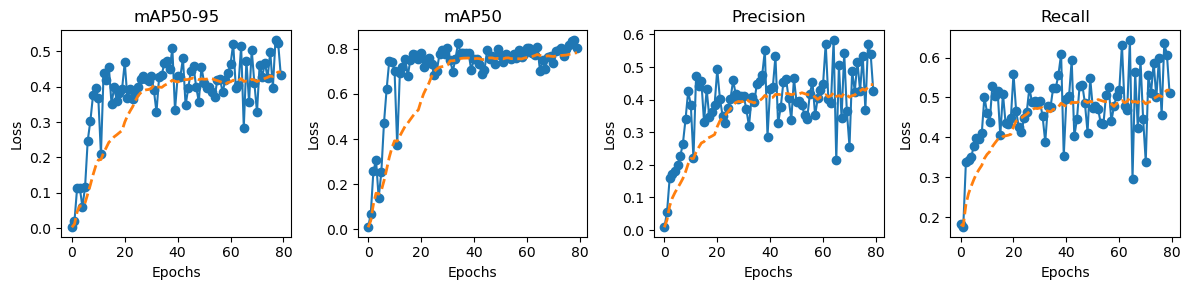

In [53]:
import matplotlib.pyplot as plt

history_df = pd.read_csv('history.csv')

def smooth_data(data, window_size=20):
    return data.rolling(window=window_size, min_periods=1).mean()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].plot(history_df['val_AP'], 'o-')
axes[0].plot(smooth_data(history_df['val_AP']), '--', linewidth=2)
axes[0].set_title("mAP50-95")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(history_df['val_AP50'], 'o-')
axes[1].plot(smooth_data(history_df['val_AP50']), '--', linewidth=2)
axes[1].set_title("mAP50")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

axes[2].plot(history_df['val_APm'], 'o-', label="val loss")
axes[2].plot(smooth_data(history_df['val_APm']), '--', linewidth=2)
axes[2].set_title("Precision")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Loss")

axes[3].plot(history_df['val_ARm'], 'o-', label="val loss")
axes[3].plot(smooth_data(history_df['val_ARm']), '--', linewidth=2)
axes[3].set_title("Recall")
axes[3].set_xlabel("Epochs")
axes[3].set_ylabel("Loss")


plt.tight_layout()
plt.savefig('map.png', dpi=200)

plt.show()

In [24]:
model.evaluate(test_ds)

2024-11-08 01:03:48.049547: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-11-08 01:03:48.140170: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


156/156 [==============================] - 9s 23ms/step - loss: 0.2752 - box_loss: 0.1010 - classification_loss: 0.1743 - percent_boxes_matched_with_anchor: 0.9652


[0.2752189338207245,
 0.10095588862895966,
 0.17426297068595886,
 0.9651942849159241]

In [25]:
map_metric = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format='xywh',
    evaluate_freq=0.5,
)

for images, ytrue in test_ds:
    ypred = model.predict(images)

    ypred = bounding_box.to_ragged(ypred)
    ytrue = bounding_box.to_ragged(ytrue)

    map_metric.update_state(ytrue, ypred)

1/1 [==============================] - 0s 196ms/step


In [26]:
print(f"map50    : {map_metric.result()['MaP@[IoU=50]']}")
print(f"map50-95 : {map_metric.result()['MaP']}")
print(f"recall   : {map_metric.result()['Recall@[area=medium]']}")

map50    : 0.8356977701187134
map50-95 : 0.5326208472251892
recall   : 0.6359201669692993


In [27]:
map_metric.result()

{'MaP': <tf.Tensor: shape=(), dtype=float32, numpy=0.53262085>,
 'MaP@[IoU=50]': <tf.Tensor: shape=(), dtype=float32, numpy=0.83569777>,
 'MaP@[IoU=75]': <tf.Tensor: shape=(), dtype=float32, numpy=0.600081>,
 'MaP@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.35425255>,
 'MaP@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.56985307>,
 'MaP@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.7321235>,
 'Recall@[max_detections=1]': <tf.Tensor: shape=(), dtype=float32, numpy=0.58046204>,
 'Recall@[max_detections=10]': <tf.Tensor: shape=(), dtype=float32, numpy=0.5866342>,
 'Recall@[max_detections=100]': <tf.Tensor: shape=(), dtype=float32, numpy=0.5866342>,
 'Recall@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.38596314>,
 'Recall@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.63592017>,
 'Recall@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.7952632>}